In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

from src.crimp import crimp
from src.baselines import rank_degree, rank_betweenness, rank_pagerank, rank_cycle_ratio_base

In [2]:
def topk_from_scores(score_dict, k):
    return [n for n, _ in sorted(score_dict.items(), key=lambda x: x[1], reverse=True)[:k]]

def rank_crimp(G):
    return crimp(G).r_imp

In [3]:
def giant_component_fraction(G):
    """Return size of the largest connected component divided by number of nodes."""
    n = G.number_of_nodes()
    if n == 0:
        return 0.0
    gcc = max((len(c) for c in nx.connected_components(G)), default=0)
    return gcc / n

def targeted_removal_curve(G, ordering):
    """
    Remove nodes in 'ordering' sequentially.
    Returns a DataFrame with fraction removed and gcc fraction after each step.
    """
    H = G.copy()
    n0 = H.number_of_nodes()

    removed = 0
    rows = [{"removed_frac": 0.0, "gcc_frac": giant_component_fraction(H)}]

    for node in ordering:
        if H.has_node(node):
            H.remove_node(node)
            removed += 1
            rows.append({
                "removed_frac": removed / n0,
                "gcc_frac": giant_component_fraction(H)
            })

    return pd.DataFrame(rows)

In [4]:
G = nx.karate_club_graph()

rankers = {
    "CRimp": rank_crimp,
    "CycleRatioBase": rank_cycle_ratio_base,
    "Degree": rank_degree,
    "Betweenness": rank_betweenness,
    "PageRank": rank_pagerank,
}

curves = []
for name, fn in rankers.items():
    scores = fn(G)
    ordering = [n for n, _ in sorted(scores.items(), key=lambda x: x[1], reverse=True)]
    df_curve = targeted_removal_curve(G, ordering)
    df_curve["method"] = name
    curves.append(df_curve)

perc_df = pd.concat(curves, ignore_index=True)
perc_df.head()

,removed_frac,gcc_frac,method
0,0.000000,1.000000,CRimp
1,0.029412,1.000000,CRimp
2,0.058824,0.812500,CRimp
3,0.088235,0.645161,CRimp
4,0.117647,0.333333,CRimp


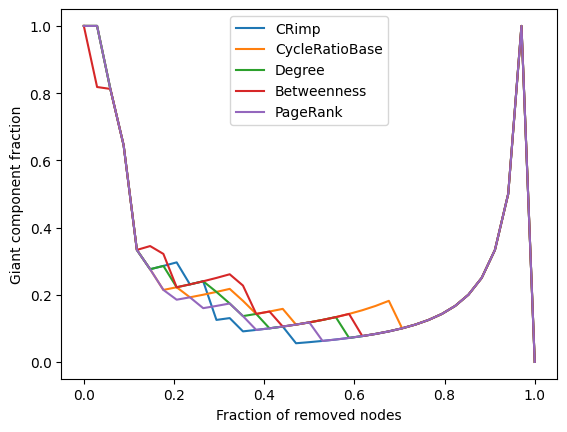

In [5]:
for method in perc_df["method"].unique():
    tmp = perc_df[perc_df["method"] == method]
    plt.plot(tmp["removed_frac"], tmp["gcc_frac"], label=method)

plt.xlabel("Fraction of removed nodes")
plt.ylabel("Giant component fraction")
plt.legend()
plt.show()

In [6]:
def auc(x, y):
    return float(np.trapezoid(y, x))

auc_rows = []
for method in perc_df["method"].unique():
    tmp = perc_df[perc_df["method"] == method]
    auc_rows.append({"method": method, "auc": auc(tmp["removed_frac"].values, tmp["gcc_frac"].values)})

auc_df = pd.DataFrame(auc_rows).sort_values("auc")
auc_df

,method,auc
4,PageRank,0.256046
0,CRimp,0.257694
2,Degree,0.269145
3,Betweenness,0.276905
1,CycleRatioBase,0.279859


In [7]:
def auc(x, y):
    return float(np.trapezoid(y, x))

def gcc_at_points(x, y, points=(0.1, 0.2, 0.3, 0.5)):
    out = {}
    for p in points:
        out[f"gcc@{p}"] = float(np.interp(p, x, y))
    return out

def p_star(x, y, thresh=0.1):
    y = np.array(y)
    x = np.array(x)
    idx = np.where(y <= thresh)[0]
    return float(x[idx[0]]) if len(idx) else 1.0

rows = []
for method in perc_df["method"].unique():
    tmp = perc_df[perc_df["method"] == method].sort_values("removed_frac")
    x = tmp["removed_frac"].values
    y = tmp["gcc_frac"].values

    row = {"method": method}
    row["auc"] = auc(x, y)
    row["p_star_gcc_lt_0.1"] = p_star(x, y, thresh=0.1)
    row.update(gcc_at_points(x, y, points=(0.1, 0.2, 0.3, 0.5)))
    rows.append(row)

metrics_df = pd.DataFrame(rows).sort_values("auc")
metrics_df = metrics_df.sort_values("auc").reset_index(drop=True)
metrics_df_rounded = metrics_df.copy()
for col in metrics_df.columns:
    if col != "method":
        metrics_df_rounded[col] = metrics_df_rounded[col].astype(float).round(6)
metrics_df_rounded

,method,auc,p_star_gcc_lt_0.1,gcc@0.1,gcc@0.2,gcc@0.3,gcc@0.5
0,PageRank,0.256046,0.382353,0.52043,0.191005,0.168116,0.117647
1,CRimp,0.257694,0.352941,0.52043,0.294180,0.126087,0.058824
2,Degree,0.269145,0.411765,0.52043,0.234921,0.201449,0.117647
3,Betweenness,0.276905,0.617647,0.52043,0.242063,0.252174,0.117647
4,CycleRatioBase,0.279859,0.705882,0.52043,0.220635,0.210145,0.117647


In [8]:
top10 = {}
for name, fn in rankers.items():
    scores = fn(G)
    ordering = [n for n,_ in sorted(scores.items(), key=lambda x: x[1], reverse=True)]
    top10[name] = ordering[:10]

pd.DataFrame({k: pd.Series(v) for k,v in top10.items()})

,CRimp,CycleRatioBase,Degree,Betweenness,PageRank
0,33,33,33,0,33
1,0,0,0,33,0
2,32,32,32,32,32
3,2,2,2,2,2
4,1,1,1,31,1
5,5,31,3,8,31
6,6,19,31,1,23
7,31,27,8,13,3
8,3,8,13,19,5
9,23,5,23,5,13


In [9]:
OUT_DIR = Path("../results")
OUT_DIR.mkdir(parents=True, exist_ok=True)
metrics_df.to_csv(OUT_DIR / "percolation_metrics_karate.csv", index=False)